(faster_sampling_notebook)=

# Faster Sampling with JAX and Numba

:::{post} July 11, 2023
:tags: hierarchical model, JAX, numba, scaling
:category: reference, intermediate
:author: Thomas Wiecki
:::

PyMC offers multiple sampling backends that can dramatically improve performance depending on your model size and requirements. Each backend has distinct advantages and is optimized for different use cases.

### PyMC's Built-in Sampler

```python
pm.sample()
```

The default PyMC sampler uses a Python-based NUTS implementation that provides maximum compatibility with all PyMC features. This sampler is always used when working with models that contain discrete variables, as it's the only option that supports non-gradient based samplers like Slice and Metropolis. While this sampler can compile the underlying model to different backends (C, Numba, or JAX) using the `compile_kwargs` parameter, it still maintains Python overhead that can limit performance for large models.

### Nutpie Sampler

```python
pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "numba"})
pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax"})
pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "pytensor"})
```

Nutpie is on the cutting-edge of PyMC sampling performance. Written in Rust, it eliminates most Python overhead and provides exceptional performance for continuous models. The Numba backend typically offers the highest performance for most use cases, while the JAX backend excels with very large models and provides GPU acceleration capabilities. Nutpie is particularly well-suited for production workflows where sampling speed is critical.

### NumPyro Sampler

```python
pm.sample(nuts_sampler="numpyro", nuts_sampler_kwargs={"chain_method": "parallel"})
# GPU-accelerated
pm.sample(nuts_sampler="numpyro", nuts_sampler_kwargs={"chain_method": "vectorized"})
```

NumPyro provides a mature JAX-based sampling implementation that integrates seamlessly with the broader JAX ecosystem. This sampler typically performs best with small to medium-sized models and offers excellent GPU support. NumPyro benefits from years of development within the JAX community and provides reliable performance characteristics, though it may have compilation overhead for very large models.

### BlackJAX Sampler

```python
pm.sample(nuts_sampler="blackjax")
```

BlackJAX offers another JAX-based sampling implementation focused on flexibility and research applications. While it provides similar capabilities to NumPyro, it's less commonly used in production environments. BlackJAX can be valuable for experimental workflows or when specific JAX-based features are required that aren't available in other samplers.

## Performance Guidelines

Understanding when to use each sampler depends on several key factors including model size, variable types, and computational requirements.

**Model Size Considerations**

For small models, NumPyro typically provides the best balance of performance and reliability. The compilation overhead is minimal, and the mature JAX implementation handles these models efficiently. Larger models often benefit from Nutpie with the Numba backend, which provides excellent performance without the memory overhead sometimes associated with JAX compilation.

Large models generally perform best with either Nutpie's JAX backend or Nutpie's Numba backend. The choice between these depends on whether GPU acceleration is needed and how the model's computational graph interacts with each backend's optimization strategies.

**Variable Type Requirements**

Models containing discrete variables have no choice but to use PyMC's built-in sampler, as it's the only implementation that supports the necessary Slice and Metropolis sampling algorithms. For purely continuous models, all sampling backends are available, making performance the primary consideration.

**Computational Backend Selection**

Numba excels at CPU optimization and provides consistent performance across different model types. It's particularly effective for models with complex mathematical operations that benefit from just-in-time compilation. JAX offers superior performance for very large models and provides natural GPU acceleration, making it ideal when computational resources are a limiting factor. The traditional C backend serves as a reliable fallback option with broad compatibility but typically offers lower performance than the alternatives.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

rng = np.random.default_rng(seed=42)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.22.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

We'll demonstrate the performance differences using a Probabilistic Principal Component Analysis (PPCA) model.

In [3]:
def build_toy_dataset(N, D, K, sigma=1):
    x_train = np.zeros((D, N))
    w = rng.normal(
        0.0,
        2.0,
        size=(D, K),
    )
    z = rng.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    for d in range(D):
        for n in range(N):
            x_train[d, n] = rng.normal(mean[d, n], sigma)

    print("True principal axes:")
    print(w)
    return x_train


N = 5000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

data = build_toy_dataset(N, D, K)

True principal axes:
[[ 0.60943416]
 [-2.07996821]]


Text(0.5, 1.0, 'Simulated data set')

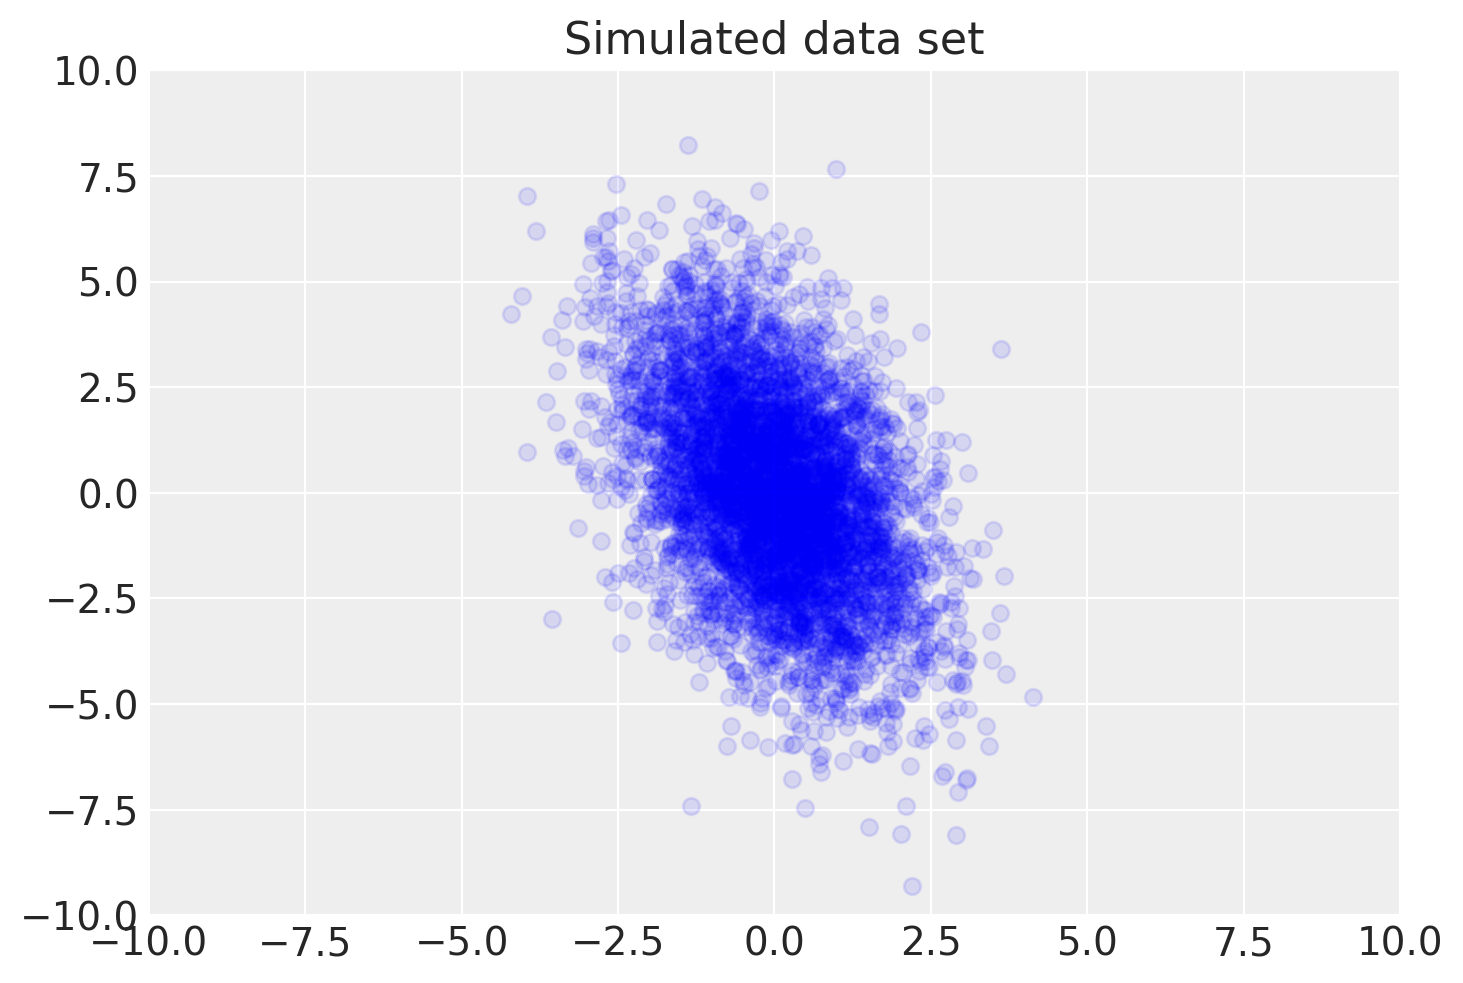

In [4]:
plt.scatter(data[0, :], data[1, :], color="blue", alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")

In [5]:
with pm.Model() as PPCA:
    w = pm.Normal("w", mu=0, sigma=2, shape=[D, K], transform=pm.distributions.transforms.Ordered())
    z = pm.Normal("z", mu=0, sigma=1, shape=[N, K])
    x = pm.Normal("x", mu=w.dot(z.T), sigma=1, shape=[D, N], observed=data)

## Performance Comparison

Now let's compare the performance of different sampling backends on our PPCA model. We'll measure both compilation time and sampling speed.

### 1. PyMC Default Sampler (Python NUTS)

In [6]:
%%time
with PPCA:
    idata_pymc = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 16 s, sys: 417 ms, total: 16.4 s
Wall time: 22.4 s


### 2. Nutpie with Numba Backend

In [7]:
%%time
with PPCA:
    idata_nutpie_numba = pm.sample(
        nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "numba"}, progressbar=False
    )

CPU times: user 45.6 s, sys: 813 ms, total: 46.5 s
Wall time: 35.6 s


### 3. Nutpie with JAX Backend

In [8]:
%%time
with PPCA:
    idata_nutpie_jax = pm.sample(
        nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax"}, progressbar=False
    )

CPU times: user 33.8 s, sys: 9.67 s, total: 43.5 s
Wall time: 16.9 s


### 4. NumPyro Sampler

In [9]:
%%time
with PPCA:
    idata_numpyro = pm.sample(nuts_sampler="numpyro", progressbar=False)

/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 53.8 s, sys: 2.47 s, total: 56.3 s
Wall time: 44.3 s


## Installation Requirements

To use the various sampling backends, you need to install the corresponding packages. Nutpie is the recommended high-performance option and can be installed with pip or conda/mamba (e.g. `conda install nutpie`). For JAX-based workflows, NumPyro provides mature functionality and is installed with the `numpyro` package. BlackJAX offers an alternative JAX implementation and is available in the `blackjax` package.

## Special Cases and Advanced Usage

### Using PyMC's Built-in Sampler with Different Backends

In certain scenarios, you may need to use PyMC's Python-based sampler while still benefiting from faster computational backends. This situation commonly arises when working with models that contain discrete variables, which require PyMC's specialized sampling algorithms. Even in these cases, you can significantly improve performance by compiling the model's computational graph to more efficient backends.

The following examples demonstrate how to use PyMC's built-in sampler with different compilation targets. The `fast_run` mode uses optimized C compilation, which provides good performance while maintaining full compatibility. The `numba` mode offers the only way to access Numba's just-in-time compilation benefits when using PyMC's sampler. The `jax` mode enables JAX compilation, though for JAX workflows, Nutpie or NumPyro typically provide better performance.

In [10]:
with PPCA:
    idata_c = pm.sample(nuts_sampler="pymc", compile_kwargs={"mode": "fast_run"})

# with PPCA:
#     idata_pymc_numba = pm.sample(nuts_sampler="pymc", compile_kwargs={"mode": "numba"})

# with PPCA:
#     idata_pymc_jax = pm.sample(nuts_sampler="pymc", compile_kwargs={"mode": "jax"})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, z]
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The above examples are commented out to avoid redundant sampling in this demonstration notebook. In practice, you would uncomment and run the configuration that matches your model's requirements. These compilation modes allow you to access faster computational backends even when you must use PyMC's Python-based sampler for compatibility reasons.

### Models with Discrete Variables

When working with models that contain discrete variables, you have no choice but to use PyMC's built-in sampler. This is because discrete variables require specialized sampling algorithms like Slice sampling or Metropolis-Hastings that are only available in PyMC's Python implementation. The example below demonstrates a typical scenario where this constraint applies.

In [11]:
with pm.Model() as discrete_model:
    cluster = pm.Categorical("cluster", p=[0.3, 0.7], shape=100)
    mu = pm.Normal("mu", 0, 1, shape=2)
    sigma = pm.HalfNormal("sigma", 1, shape=2)
    obs = pm.Normal("obs", mu=mu[cluster], sigma=sigma[cluster], observed=rng.normal(0, 1, 100))

    trace_discrete = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [cluster]
>NUTS: [mu, sigma]
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Authors

- Originally authored by Thomas Wiecki in July 2023  
- Substantially updated and expanded by Chris Fonnesbeck in May 2025

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Sat May 24 2025

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.2.0

pytensor: 2.30.3
aeppl   : not installed
xarray  : 2025.4.0

numpy     : 2.2.6
pymc      : 5.22.0
matplotlib: 3.10.3
arviz     : 0.21.0

Watermark: 2.5.0



:::{include} ../page_footer.md
:::